# Homework and bake-off: Stanford Sentiment Treebank

In [1]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Fall 2020"

## Contents

1. [Overview](#Overview)
1. [Methodological note](#Methodological-note)
1. [Set-up](#Set-up)
1. [A softmax baseline](#A-softmax-baseline)
1. [RNNClassifier wrapper](#RNNClassifier-wrapper)
1. [Error analysis](#Error-analysis)
1. [Homework questions](#Homework-questions)
  1. [Sentiment words alone [2 points]](#Sentiment-words-alone-[2-points])
  1. [A more powerful vector-averaging baseline [2 points]](#A-more-powerful-vector-averaging-baseline-[2-points])
  1. [Sentiment shifters [2 points]](#Sentiment-shifters-[2-points])
  1. [Your original system [3 points]](#Your-original-system-[3-points])
1. [Bake-off [1 point]](#Bake-off-[1-point])

## Overview

This homework and associated bake-off are devoted to the Stanford Sentiment Treebank (SST). The homework questions ask you to implement some baseline systems and some original feature functions, and the bake-off challenge is to define a system that does extremely well at the SST task.

We'll focus on the ternary task as defined by `sst.ternary_class_func` This isn't used in the literature but I think it is the best version of the SST problem for the reasons given [here](sst_01_overview.ipynb#Modeling-the-SST-labels).

The SST test set will be used for the bake-off evaluation. This dataset is already publicly distributed, so we are counting on people not to cheat by develping their models on the test set. You must do all your development without using the test set at all, and then evaluate exactly once on the test set and turn in the results, with no further system tuning or additional runs. __Much of the scientific integrity of our field depends on people adhering to this honor code__. 

Our only additional restriction is that you cannot use any of the subtree labels as input features. You can have your system learn to predict them (as intended), but no feature function can make use of them.

One of our goals for this homework and bake-off is to encourage you to engage in __the basic development cycle for supervised models__, in which you

1. Write a new feature function. We recommend starting with something simple.
1. Use `sst.experiment` to evaluate your new feature function, with at least `fit_softmax_classifier`.
1. If you have time, compare your feature function with `unigrams_phi` using `sst.compare_models` or `utils.mcnemar`. (For discussion, see [this notebook section](sst_02_hand_built_features.ipynb#Statistical-comparison-of-classifier-models).)
1. Return to step 1, or stop the cycle and conduct a more rigorous evaluation with hyperparameter tuning and assessment on the `dev` set.

[Error analysis](#Error-analysis) is one of the most important methods for steadily improving a system, as it facilitates a kind of human-powered hill-climbing on your ultimate objective. Often, it takes a careful human analyst just a few examples to spot a major pattern that can lead to a beneficial change to the feature representations.

## Methodological note

You don't have to use the experimental framework defined below (based on `sst`). However, if you don't use `sst.experiment` as below, then make sure you're training only on `train`, evaluating on `dev`, and that you report with 

```
from sklearn.metrics import classification_report
classification_report(y_dev, predictions)
```
where `y_dev = [y for tree, y in sst.dev_reader(class_func=sst.ternary_class_func)]`. We'll focus on the value at `macro avg` under `f1-score` in these reports.

## Set-up

See [the first notebook in this unit](sst_01_overview.ipynb#Set-up) for set-up instructions.

In [1]:
from collections import Counter
from nltk.tree import Tree
import numpy as np
import os
import pandas as pd
import random
from sklearn.linear_model import LogisticRegression
import sst
import torch.nn as nn
from torch_rnn_classifier import TorchRNNClassifier
from torch_tree_nn import TorchTreeNN
import utils

In [2]:
#DATA_HOME = '/Users/pierrejaumier/Data/cs224u'
DATA_HOME = utils.get_data_path()
SST_HOME = os.path.join(DATA_HOME, 'trees')

In [4]:
DATA_HOME

'/home/neo/Data/cs224u'

## A softmax baseline

This example is here mainly as a reminder of how to use our experimental framework with linear models.

In [5]:
def unigrams_phi(tree):
    """The basis for a unigrams feature function.

    Parameters
    ----------
    tree : nltk.tree
        The tree to represent.

    Returns
    -------
    Counter
        A map from strings to their counts in `tree`. (Counter maps a
        list to a dict of counts of the elements in that list.)

    """
    return Counter(tree.leaves())

Thin wrapper around `LogisticRegression` for the sake of `sst.experiment`:

In [6]:
def fit_softmax_classifier(X, y):
    mod = LogisticRegression(
        fit_intercept=True,
        solver='liblinear',
        multi_class='ovr')
    mod.fit(X, y)
    return mod

The experimental run with some notes:

In [7]:
softmax_experiment = sst.experiment(
    SST_HOME,
    unigrams_phi,                      # Free to write your own!
    fit_softmax_classifier,            # Free to write your own!
    train_reader=sst.train_reader,     # Fixed by the competition.
    assess_reader=sst.dev_reader,      # Fixed until the bake-off.
    class_func=sst.ternary_class_func) # Fixed by the bake-off rules.

              precision    recall  f1-score   support

    negative      0.628     0.689     0.657       428
     neutral      0.343     0.153     0.211       229
    positive      0.629     0.750     0.684       444

    accuracy                          0.602      1101
   macro avg      0.533     0.531     0.518      1101
weighted avg      0.569     0.602     0.575      1101



`softmax_experiment` contains a lot of information that you can use for analysis; see [this section below](#Error-analysis) for starter code.

## RNNClassifier wrapper

This section illustrates how to use `sst.experiment` with `TorchRNNClassifier`. The same basic patterns hold for using `TorchTreeNN`; see [sst_03_neural_networks.ipynb](sst_03_neural_networks.ipynb) for additional discussion.

To featurize examples for an RNN, we just get the words in order, letting the model take care of mapping them into an embedding space.

In [8]:
def rnn_phi(tree):
    return tree.leaves()

The model wrapper gets the vocabulary using `sst.get_vocab`. If you want to use pretrained word representations in here, then you can have `fit_rnn_classifier` build that space too; see [this notebook section for details](sst_03_neural_networks.ipynb#Pretrained-embeddings). See also [torch_model_base.py](torch_model_base.py) for details on the many optimization parameters that `TorchRNNClassifier` accepts.

In [9]:
def fit_rnn_classifier(X, y):
    sst_glove_vocab = utils.get_vocab(X, mincount=2)
    mod = TorchRNNClassifier(
        sst_glove_vocab,
        early_stopping=True)
    mod.fit(X, y)
    return mod

In [10]:
rnn_experiment = sst.experiment(
    SST_HOME,
    rnn_phi,
    fit_rnn_classifier,
    vectorize=False,  # For deep learning, use `vectorize=False`.
    assess_reader=sst.dev_reader)

Stopping after epoch 62. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.0903888838365674

              precision    recall  f1-score   support

    negative      0.714     0.678     0.695       428
    positive      0.704     0.739     0.721       444

    accuracy                          0.709       872
   macro avg      0.709     0.708     0.708       872
weighted avg      0.709     0.709     0.708       872



## Error analysis

This section begins to build an error-analysis framework using the dicts returned by `sst.experiment`. These have the following structure:

```
'model': trained model
'phi': the feature function used
'train_dataset':
   'X': feature matrix
   'y': list of labels
   'vectorizer': DictVectorizer,
   'raw_examples': list of raw inputs, before featurizing   
'assess_dataset': same structure as the value of 'train_dataset'
'predictions': predictions on the assessment data
'metric': `score_func.__name__`, where `score_func` is an `sst.experiment` argument
'score': the `score_func` score on the assessment data
```
The following function just finds mistakes, and returns a `pd.DataFrame` for easy subsequent processing:

In [11]:
def find_errors(experiment):
    """Find mistaken predictions.

    Parameters
    ----------
    experiment : dict
        As returned by `sst.experiment`.

    Returns
    -------
    pd.DataFrame

    """
    raw_examples = experiment['assess_dataset']['raw_examples']
    raw_examples = [" ".join(tree.leaves()) for tree in raw_examples]
    df = pd.DataFrame({
        'raw_examples': raw_examples,
        'predicted': experiment['predictions'],
        'gold': experiment['assess_dataset']['y']})
    df['correct'] = df['predicted'] == df['gold']
    return df

In [12]:
softmax_analysis = find_errors(softmax_experiment)

In [13]:
rnn_analysis = find_errors(rnn_experiment)

Here we merge the sotmax and RNN experiments into a single DataFrame:

In [14]:
analysis = softmax_analysis.merge(
    rnn_analysis, left_on='raw_examples', right_on='raw_examples')

analysis = analysis.drop('gold_y', axis=1).rename(columns={'gold_x': 'gold'})

The following code collects a specific subset of examples; small modifications to its structure will give you different interesting subsets:

In [15]:
# Examples where the softmax model is correct, the RNN is not,
# and the gold label is 'positive'

error_group = analysis[
    (analysis['predicted_x'] == analysis['gold'])
    &
    (analysis['predicted_y'] != analysis['gold'])
    &
    (analysis['gold'] == 'positive')
]

In [16]:
error_group.shape[0]

44

In [17]:
for ex in error_group['raw_examples'].sample(5):
    print("="*70)
    print(ex)

The Chateau cleverly probes the cross-cultural differences between Gauls and Yanks .
People cinema at its finest .
Preaches to two completely different choirs at the same time , which is a pretty amazing accomplishment .
Mr. Tsai is a very original artist in his medium , and What Time Is It There ?
An interesting story with a pertinent -LRB- cinematically unique -RRB- message , told fairly well and scored to perfection , I found myself struggling to put my finger on that elusive `` missing thing . ''


## Homework questions

Please embed your homework responses in this notebook, and do not delete any cells from the notebook. (You are free to add as many cells as you like as part of your responses.)

### Sentiment words alone [2 points]

NLTK includes an easy interface to [Minqing Hu and Bing Liu's __Opinion Lexicon__](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), which consists of a list of positive words and a list of negative words. How much of the ternary SST story does this lexicon tell?

For this problem, submit code to do the following:

1. Create a feature function `op_unigrams_phi` on the model of `unigrams_phi` above, but filtering the vocabulary to just items that are members of the Opinion Lexicon. Submit this feature function. You can use `test_op_unigrams_phi` to check your work.

1. Evaluate your feature function with `sst.experiment`, with all the same parameters as were used to create `softmax_experiment` in [A softmax baseline](#A-softmax-baseline) above, except of course for the feature function.

1. Use `utils.mcnemar` to compare your feature function with the results in `softmax_experiment`. The information you need for this is in `softmax_experiment` and your own `sst.experiment` results. Submit your evaluation code. You can assume `softmax_experiment` is already in memory, but your code should create the other objects necessary for this comparison.

In [18]:
import nltk
nltk.download('opinion_lexicon')

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /home/neo/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


True

In [19]:
from nltk.corpus import opinion_lexicon

# Use set for fast membership checking:
positive = set(opinion_lexicon.positive())
negative = set(opinion_lexicon.negative())

lexicon = positive | negative

def op_unigrams_phi(tree):
    """ Unigrams filtered on the Opinion Lexicon

    Parameters
    ----------
    tree : nltk.tree
        The tree to represent.

    Returns
    -------
    Counter
        A map from strings to their counts in `tree`. (Counter maps a
        list to a dict of counts of the elements in that list.)

    """
    opinion_words = [word for word in tree.leaves() if word in lexicon]        
    return Counter(opinion_words)


softmax_op_experiment = sst.experiment(
    SST_HOME,
    op_unigrams_phi,                   # Free to write your own!
    fit_softmax_classifier,            # Free to write your own!
    train_reader=sst.train_reader,     # Fixed by the competition.
    assess_reader=sst.dev_reader,      # Fixed until the bake-off.
    class_func=sst.ternary_class_func) # Fixed by the bake-off rules.

m = utils.mcnemar(
    softmax_experiment['assess_dataset']['y'],
    softmax_experiment['predictions'],
    softmax_op_experiment['predictions'])
p = "p < 0.0001" if m[1] < 0.0001 else m[1]

print("McNemar's test: {0:0.02f} ({1:})".format(m[0], p))

              precision    recall  f1-score   support

    negative      0.553     0.752     0.638       428
     neutral      0.179     0.031     0.052       229
    positive      0.615     0.664     0.639       444

    accuracy                          0.567      1101
   macro avg      0.449     0.482     0.443      1101
weighted avg      0.500     0.567     0.516      1101

McNemar's test: 5.33 (0.020980477345314247)


Quelle est l'interpretation du test de Mc Nemar?  
J'arrive pas trop à voir avec les exemples fournis. Le but semble de déterminer un ordre de grandeur de la différence entre les résultats proposés par les deux modèles, mais quelles est l'interprétation de ce chiffre? Mystère ;) ...  
https://fr.wikipedia.org/wiki/Test_de_McNemar

In [20]:
def test_op_unigrams_phi(func):
    tree = Tree.fromstring("""(4 (2 NLU) (4 (2 is) (4 amazing)))""")
    #expected = {"enlightening": 1}
    expected = {"amazing": 1}
    result = func(tree)
    assert result == expected, \
        ("Error for `op_unigrams_phi`: "
         "Got `{}` which differs from `expected` "
         "in `test_op_unigrams_phi`".format(result))

In [21]:
test_op_unigrams_phi(op_unigrams_phi)

### A more powerful vector-averaging baseline [2 points]

In [Distributed representations as features](sst_03_neural_networks.ipynb#Distributed-representations-as-features), we looked at a baseline for the ternary SST problem in which each example is modeled as the sum of its GloVe representations. A `LogisticRegression` model was used for prediction. A neural network might do better with these representations, since there might be complex relationships between the input feature dimensions that a linear classifier can't learn. 

To address this question, we want to get set up to run the experiment with a shallow neural classifier. Thus, your task is to write and submit a model wrapper function around `TorchShallowNeuralClassifier`. This function should implement hyperparameter search according to this specification:

* Set `early_stopping=True` for all experiments.
* Using 3-fold cross-validation, exhaustively explore this set of hyperparameter combinations:
  * The hidden dimensionality at 50, 100, and 200.
  * The hidden activation function as `nn.Tanh()` and `nn.ReLU()`.
* For all other parameters to `TorchShallowNeuralClassifier`, use the defaults.


See [this notebook section](sst_02_hand_built_features.ipynb#Hyperparameter-search) for examples. You are not required to run a full evaluation with this function using `sst.experiment`, but we assume you will want to.

We're not evaluating the quality of your model. (We've specified the protocols completely, but there will still be variation in the results.) However, the primary goal of this question is to get you thinking more about this strong baseline feature representation scheme for SST, so we're sort of hoping you feel compelled to try out variations on your own.

In [22]:
# Dictionnaire mot -> vecteur de type GloVe
GLOVE_HOME = os.path.join(DATA_HOME, 'glove.6B')

glove_lookup = utils.glove2dict(
    os.path.join(GLOVE_HOME, 'glove.6B.300d.txt'))

In [23]:
def vsm_leaves_phi(tree, lookup, np_func=np.mean):
    """Represent `tree` as a combination of the vector of its words.

    Parameters
    ----------
    tree : nltk.Tree

    lookup : dict
        From words to vectors.

    np_func : function (default: np.mean)
        A numpy matrix operation that can be applied columnwise,
        like `np.mean`, `np.sum`, or `np.prod`. The requirement is that
        the function take `axis=0` as one of its arguments (to ensure
        columnwise combination) and that it return a vector of a
        fixed length, no matter what the size of the tree is.

    Returns
    -------
    np.array, dimension `X.shape[1]`

    """
    allvecs = np.array([lookup[w] for w in tree.leaves() if w in lookup])
    if len(allvecs) == 0:
        dim = len(next(iter(lookup.values())))
        feats = np.zeros(dim)
    else:
        feats = np_func(allvecs, axis=0)
    return feats

In [24]:
def glove_leaves_phi(tree, np_func=np.sum):
    return vsm_leaves_phi(tree, glove_lookup, np_func=np_func)

In [25]:
# Version avec la régression logistique
def fit_maxent_classifier(X, y):
    mod = LogisticRegression(
        fit_intercept=True,
        solver='liblinear',
        multi_class='auto')
    mod.fit(X, y)
    return mod

In [26]:
%%time
_ = sst.experiment(
    SST_HOME,
    glove_leaves_phi,
    fit_maxent_classifier,
    vectorize=False)  # Tell `experiment` that we already have our feature vectors.

              precision    recall  f1-score   support

    negative      0.754     0.775     0.765       987
    positive      0.791     0.771     0.781      1089

    accuracy                          0.773      2076
   macro avg      0.773     0.773     0.773      2076
weighted avg      0.774     0.773     0.773      2076

CPU times: user 3.32 s, sys: 24.1 ms, total: 3.34 s
Wall time: 3.34 s


In [27]:
from torch_shallow_neural_classifier import TorchShallowNeuralClassifier

def fit_shallow_neural_classifier_with_hyperparameter_search(X, y):
    """
    Parameters
    ----------
    X : 2d np.array
        The matrix of features, one example per row.

    y : list
        The list of labels for rows in `X`.

    Returns
    -------
    TorchShallowNeuralClassifier
        A trained model instance, the best model found.

    """
    base_model = TorchShallowNeuralClassifier(early_stopping=True)
    
    cv = 3 # folders for cross-validation
    param_grid = {
        #'hidden_dim': [50, 100, 200],
        #'hidden_dim': [500, 600, 700],
        #'hidden_activation': [nn.Tanh(), nn.ReLU()] }
        'hidden_dim': [200],
        'hidden_activation': [nn.Tanh()] }


    best_model = utils.fit_classifier_with_hyperparameter_search(
        X, y, base_model, cv, param_grid)
    return best_model

In [28]:
shallow_nc_experiment = sst.experiment(
    SST_HOME,
    glove_leaves_phi,
    fit_shallow_neural_classifier_with_hyperparameter_search,
    train_reader = sst.train_reader,
    assess_reader = sst.dev_reader,
    class_func = sst.ternary_class_func,
    vectorize = False)

Stopping after epoch 56. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 3.1222888827323914

Best params: {'hidden_activation': Tanh(), 'hidden_dim': 200}
Best score: 0.532
              precision    recall  f1-score   support

    negative      0.624     0.703     0.662       428
     neutral      0.342     0.170     0.227       229
    positive      0.673     0.766     0.717       444

    accuracy                          0.618      1101
   macro avg      0.547     0.546     0.535      1101
weighted avg      0.585     0.618     0.593      1101



Meilleure configuration d'hyperparamètres:  
{'hidden_activation': Tanh(), 'hidden_dim': 200}  
Pour la mesure macro-average = 0.534 on reste loin de la version avec le classificateur maxent, basé sur la régression logistique qui donnait un score de 0.792

### Sentiment shifters [2 points]

Some words have greater power than others to shift sentiment around. Because the SST has sentiment labels on all of its subconstituents, it provides an opportunity to study these shifts in detail. This question takes a first step in that direction by asking you to identify some of these sentiment shifters automatically.

More specifically, the task is to identify words that effect a particularly large shift between the value of their sibling node and the value of their mother node. For instance, in the tree

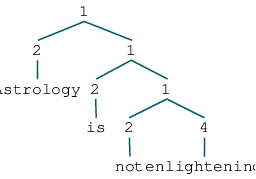

In [3]:
tree = Tree.fromstring(
    """(1 (2 Astrology) (1 (2 is) (1 (2 not) (4 enlightening))))""")

tree

we have the shifter calculations:
    
* *not*: `1 - 4 = -3`
* *enlightening*: `1 - 2 = -1`
* *is*: `1 - 1 = 0`
* *Astrology*: `1 - 1 = 0`.
    
__Your task__: write a function `sentiment_shifters` that accepts a `tree` argument and returns a dict mapping words to their list of shifts in `tree`. You can then run `view_top_shifters` to see the results. In addition, you can use `test_sentiment_shifters` to test your function directly. It uses the above example as the basis for the test.

__Tips__:

* You'll probably want to use `tree.subtrees()` to inspect all of the subtrees in each tree.
* `len(tree)` counts the number of children (immediate descendants) of `tree`.
* `isinstance(subtree[0][0], str)` will test whether the left daughter of subtree has a lexical child.
* `tree.label()` gives the label for any tree or subtree.
* Your SST reader should use `replace_root_score=False` so that you keep the root node label.

Quand on regarde les exemples d'arbres proposés sur https://nlp.stanford.edu/sentiment/treebank.html  
il semblerait qu'un noeud mère ne puisse pas avoir plus de deux enfants  
On va se baser sur cette option pour le code  
ref trees: https://www.nltk.org/api/nltk.html?highlight=tree#module-nltk.tree  

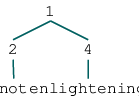

In [29]:
tree[1][1]

In [31]:
# Première exploration de la structure d'un arbre
for subtree in tree.subtrees(lambda t: t.height() > 2):
    # La fonction lambda est utilisée
    # car les mots sont à l'extrémité d'un sous-arbre mono branche
    # de hauteur 2
    print('mother_node = ', subtree.label())
    mother_node = subtree.label()
    children = [subtree[s] for s in range(len(subtree))]
    for idx, child in enumerate(children):
        siblings = [sibling for i, sibling in enumerate(children) if i != idx]
        print('\tchild ', child)
        print('\tsiblings ', siblings, '\n')

mother_node =  1
	child  (2 Astrology)
	siblings  [Tree('1', [Tree('2', ['is']), Tree('1', [Tree('2', ['not']), Tree('4', ['enlightening'])])])] 

	child  (1 (2 is) (1 (2 not) (4 enlightening)))
	siblings  [Tree('2', ['Astrology'])] 

mother_node =  1
	child  (2 is)
	siblings  [Tree('1', [Tree('2', ['not']), Tree('4', ['enlightening'])])] 

	child  (1 (2 not) (4 enlightening))
	siblings  [Tree('2', ['is'])] 

mother_node =  1
	child  (2 not)
	siblings  [Tree('4', ['enlightening'])] 

	child  (4 enlightening)
	siblings  [Tree('2', ['not'])] 



In [32]:
# Calcul des influences `shift` associées aux mots
for subtree in tree.subtrees(lambda t: t.height() > 2):
    #print('mother_node = ', subtree.label())
    mother_node = int(subtree.label())
    children = [subtree[s] for s in range(len(subtree))]
    for idx, child in enumerate(children):
        siblings = [sibling for i, sibling in enumerate(children) if i != idx]
        if isinstance(child[0], str):
            word = child[0]
            assert len(siblings) == 1  # cf hypothèse de départ
            sibling = siblings[0]
            sibling_node = int(sibling.label())
            shift = mother_node - sibling_node
            print(word, shift)

Astrology 0
is 0
not -3
enlightening -1


In [33]:
from collections import defaultdict
from operator import itemgetter

def sentiment_shifters(tree, diffs=defaultdict(list)):
    """
    Calculates the shifts in `tree`.

    Parameters
    ----------
    tree : nltk.tree.Tree

    diffs: defaultdict(list)
        This accumulates the results for `tree`, and `view_top_shifters`
        accumulates all these results into a single dict.

    Returns
    -------
    defaultdict mapping words to their list of shifts in `tree`.

    """
    # defaultdict permet de gérer les clés absentes
    # https://docs.python.org/3.7/library/collections.html#collections.defaultdict
    
    for subtree in tree.subtrees(lambda t: t.height() > 2):
        mother_node = int(subtree.label())
        children = [subtree[s] for s in range(len(subtree))]
        for idx, child in enumerate(children):
            siblings = [sibling for i, sibling in enumerate(children) if i != idx]
            if isinstance(child[0], str):
                word = child[0]
                assert len(siblings) == 1  # cf hypothèse de départ
                sibling = siblings[0]
                sibling_node = int(sibling.label())
                shift = mother_node - sibling_node

                diffs[word].append(shift)
    
    return diffs

In [34]:
def test_sentiment_shifters(func):
    """func should be `sentiment_shifters`"""
    tree = Tree.fromstring(
        """(1 (2 Astrology) (1 (2 is) (1 (2 not) (4 enlightening))))""")
    expected = {"not": [-3], "enlightening": [-1], "is": [0], "Astrology": [0]}
    result = func(tree)
    #assert result == expected, \
    assert result == expected, \
        ("Error for `sentiment_shifters`: "
         "Got\n\n\t{}\n\nwhich differs from `expected` "
         "in `test_sentiment_shifters`".format(result))

In [35]:
test_sentiment_shifters(sentiment_shifters)

In [36]:
# defaultdict permet de gérer les clés absentes
# https://docs.python.org/3.7/library/collections.html#collections.defaultdict
s = [('yellow', 1), ('blue', 2), ('yellow', 3), ('blue', 4), ('red', 1)]
d = defaultdict(list)
for k, v in s:
    d[k].append(v)
d

defaultdict(list, {'yellow': [1, 3], 'blue': [2, 4], 'red': [1]})

In [37]:
d  = {'a':[1]}
dd = defaultdict(list)
dd['a'].append(1)
assert dd == d

The following utility will let you use `sentiment_shifters`. The resulting insights could inform new feature functions.

In [38]:
def view_top_shifters(top_n=10, mincount=100):
    diffs = defaultdict(list)
    for tree, label in sst.train_reader(SST_HOME) :
        these_diffs = sentiment_shifters(tree, diffs=diffs)
    diffs = {key: np.mean(vals) for key, vals in diffs.items()
             if len(vals) >= mincount}
    diffs = sorted(diffs.items(), key=itemgetter(1))
    segs = (("Negative", diffs[:top_n]), ("Positive", diffs[-top_n:]))
    for label, seg in segs:
        print("\nTop {} {} shifters:\n".format(top_n, label))
        for key, val in seg:
            print(key, val)


view_top_shifters()


Top 10 Negative shifters:

bad -1.06
n't -0.5087976539589443
too -0.4913494809688581
does -0.4639175257731959
no -0.4260089686098655
not -0.3505535055350554
nothing -0.34615384615384615
never -0.32786885245901637
could -0.2847682119205298
little -0.21608040201005024

Top 10 Positive shifters:

see 0.24369747899159663
better 0.4274193548387097
humor 0.4803921568627451
well 0.518796992481203
love 0.5357142857142857
good 0.876984126984127
fun 0.9134615384615384
funny 0.9238095238095239
great 1.1523809523809523
best 1.196078431372549


### Your original system [3 points]

Your task is to develop an original model for the SST ternary problem, predicting only the root-level labels. There are many options. If you spend more than a few hours on this homework problem, you should consider letting it grow into your final project! Here are some relatively manageable ideas that you might try:

1. We didn't systematically evaluate the `bidirectional` option to the `TorchRNNClassifier`. Similarly, that model could be tweaked to allow multiple LSTM layers (at present there is only one), and you could try adding layers to the classifier portion of the model as well.

1. We've already glimpsed the power of rich initial word representations, and later in the course we'll see that smart initialization usually leads to a performance gain in NLP, so you could perhaps achieve a winning entry with a simple model that starts in a great place.

1. Our [practical introduction to contextual word representations](contextualreps.ipynb) covers pretrained representations and interfaces that are likely to boost the performance of any system.

1. The `TreeNN` and `TorchTreeNN` don't perform all that well, and this could be for the same reason that RNNs don't peform well: the gradient signal doesn't propagate reliably down inside very deep trees. [Tai et al. 2015](https://www.aclweb.org/anthology/P15-1150/) sought to address this with TreeLSTMs, which are fairly easy to implement in PyTorch.

We want to emphasize that this needs to be an __original__ system. It doesn't suffice to download code from the Web, retrain, and submit. You can build on others' code, but you have to do something new and meaningful with it.

In the cell below, please provide a brief technical description of your original system, so that the teaching team can gain an understanding of what it does. This will help us to understand your code and analyze all the submissions to identify patterns and strategies.  We also ask that you report the best score your system got during development, just to help us understand how systems performed overall.

In [ ]:
# PLEASE MAKE SURE TO INCLUDE THE FOLLOWING BETWEEN THE START AND STOP COMMENTS:
#   1) Textual description of your system.
#   2) The code for your original system.
#   3) The score achieved by your system in place of MY_NUMBER.
#        With no other changes to that line.
#        You should report your score as a decimal value <=1.0
# PLEASE MAKE SURE NOT TO DELETE OR EDIT THE START AND STOP COMMENTS

# START COMMENT: Enter your system description in this cell.
# My peak score was: MY_NUMBER
if 'IS_GRADESCOPE_ENV' not in os.environ:
    pass

# STOP COMMENT: Please do not remove this comment.

## Bake-off [1 point]

As we said above, the bake-off evaluation data is the official SST test-set release. For this bake-off, you'll evaluate your original system from the above homework problem on the test set, using the ternary class problem. Rules:

1. Only one evaluation is permitted.
1. No additional system tuning is permitted once the bake-off has started.

The cells below this one constitute your bake-off entry.

Systems that enter will receive the additional homework point, and systems that achieve the top score will receive an additional 0.5 points. We will test the top-performing systems ourselves, and only systems for which we can reproduce the reported results will win the extra 0.5 points.

Late entries will be accepted, but they cannot earn the extra 0.5 points. Similarly, you cannot win the bake-off unless your homework is submitted on time.

The announcement will include the details on where to submit your entry.

In [ ]:
# Enter your bake-off assessment code in this cell.
# Place your code in the scope of the 'IS_GRADESCOPE_ENV'
# conditional.
# Please do not remove this comment.
if 'IS_GRADESCOPE_ENV' not in os.environ:
    pass
    # Please enter your code in the scope of the above conditional.
    ##### YOUR CODE HERE


In [ ]:
# On an otherwise blank line in this cell, please enter
# your macro-average F1 value as reported by the code above.
# Please enter only a number between 0 and 1 inclusive.
# Please do not remove this comment.
if 'IS_GRADESCOPE_ENV' not in os.environ:
    pass
    # Please enter your score in the scope of the above conditional.
    ##### YOUR CODE HERE
